In [1]:
import sys
import os
import rasterio

module_path = os.path.abspath(os.path.join('/workspace/Transformer_OD_TPU'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

In [5]:
import main

In [118]:
dataset = 'initial_data'
crop = 800

In [119]:
# build list of ids which are valid for all cropping datasets
experiment = f'detr_output_256_binary_skip'
if dataset == 'initial_data':
    mean = 6.6374
    std = 10.184
elif dataset == 'transfer_data':
    mean = 0.7294
    std = 9.3929
output_dir = os.path.join('/workspace/',experiment)
sys.argv =  ['main.py', '--num_classes', '2', '--coco_path', f'/workspace/processed_data_v7/{dataset}', '--num_workers', '0', '--resume', f'{output_dir}/best_checkpoint.pth', '--batch_size', '1', '--crop', '256']
parser = main.get_args_parser()
args = parser.parse_args()
dataset_val = build_dataset(image_set='test', args=args)
limited_ids = dataset_val.ids

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [120]:
# choose experiment for visualization
experiment = f'detr_output_{crop}_binary_skip'
if dataset == 'initial_data':
    mean = 6.6374
    std = 10.184
elif dataset == 'transfer_data':
    mean = 0.7294
    std = 9.3929
output_dir = os.path.join('/workspace/',experiment)
vis_dir = os.path.join('/workspace/',experiment,f'{dataset}_test_outputs')

sys.argv =  ['main.py', '--num_classes', '2', '--coco_path', f'/workspace/processed_data_v7/{dataset}', '--num_workers', '0', '--resume', f'{output_dir}/best_checkpoint.pth', '--batch_size', '1', '--crop', f'{crop}']
os.makedirs(vis_dir, exist_ok=True)

In [121]:
parser = main.get_args_parser()
args = parser.parse_args()

In [122]:
dataset_test = build_dataset(image_set='test', args=args)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [123]:
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
data_loader_test = DataLoader(dataset_test, 1, sampler=sampler_test,
                            drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

In [124]:
device = torch.device(args.device)
model, criterion, postprocessors = build_model(args)
model = model.to(device).eval()

In [125]:
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [126]:
def plot_inputs(sample):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

def plot_outputs(sample, prob, boxes):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='r', linewidth=3))
        cl = p.argmax()
        text = f'{p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.8))
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

def rescale_bboxes(out_bbox, shape):
    w, h = shape
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([w, h, w, h], dtype=torch.float32).to(device)
    return b

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

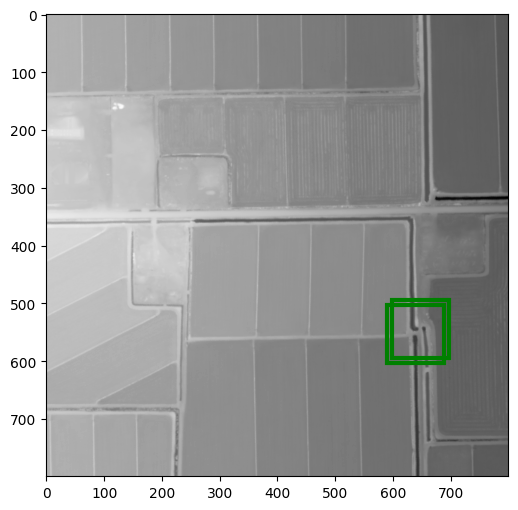

In [127]:
sample = next(iter(data_loader_test))
plot_inputs(sample)

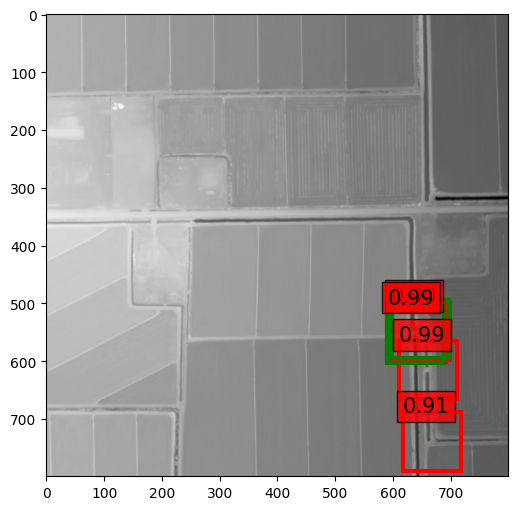

In [128]:
samples, targets, name = sample
samples = samples.to(device)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
outputs = model(samples)
image = sample[0].tensors[0].cpu().numpy()[0,:,:]

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.shape)

plot_outputs(sample, probas[keep], bboxes_scaled)

In [129]:
def plot_results(sample, prob, boxes, idx):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='r', linewidth=3))
        cl = p.argmax()
        text = f'{p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.8))
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

    plt.savefig(os.path.join(vis_dir,f'{idx}_output.png'))
    plt.close()

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, shape):
    w, h = shape
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([w, h, w, h], dtype=torch.float32).to(device)
    return b

In [130]:
for idx, sample in enumerate(tqdm(data_loader_test)):
    samples, targets, name = sample
    if name[0].item() not in limited_ids:
        continue
    if name[0].item() % 5 != 0:
        continue
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(samples)
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.shape)

    name = name[0].item()
    plot_results(sample, probas[keep], bboxes_scaled, name)

100%|█████████████████████████████████████| 545/545 [00:15<00:00, 34.78it/s]
